## Importing required libraries

In [3]:
%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%capture

Defining helper functions

In [4]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\d", '', s)

    return s

## Language modeling

In [5]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

## Tokenization

In [6]:
from nltk.tokenize import word_tokenize

def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w) for w in tokens]
    return [
        w.lower() for w in tokens if len(w) != 0
        or
        not (w in string.punctuation)
    ]

tokens = preprocess(song)

In [7]:
print(tokens[0:10])

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']


In [8]:
fdist = nltk.FreqDist(tokens)

<FreqDist with 80 samples and 385 outcomes>


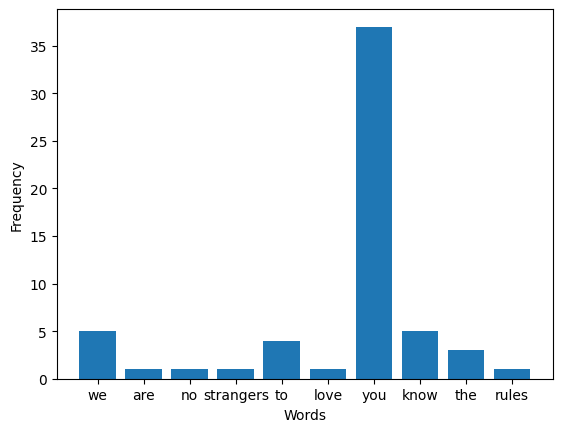

In [9]:
plt.bar(list(fdist.keys())[0:10], list(fdist.values())[0:10])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [10]:
C = sum(fdist.values())

In [12]:
print(fdist["strangers"]/C)

0.0025974025974025974


In [13]:
vocabulary = set(tokens)

In [14]:
bigrams = nltk.bigrams(tokens)
print(bigrams)

<generator object bigrams at 0x000002B9A35AA500>


In [15]:
my_bigrams = list(nltk.bigrams(tokens))

In [16]:
print(my_bigrams[0:10])

[('we', 'are'), ('are', 'no'), ('no', 'strangers'), ('strangers', 'to'), ('to', 'love'), ('love', 'you'), ('you', 'know'), ('know', 'the'), ('the', 'rules'), ('rules', 'and')]


In [17]:
freq_bigrams = nltk.FreqDist(nltk.bigrams(tokens))
print(freq_bigrams[('we', 'are')])

1


In [18]:
for my_bigram in my_bigrams[0:10]:
    print(my_bigram)
    print(freq_bigrams[my_bigram])

('we', 'are')
1
('are', 'no')
1
('no', 'strangers')
1
('strangers', 'to')
1
('to', 'love')
1
('love', 'you')
1
('you', 'know')
1
('know', 'the')
3
('the', 'rules')
1
('rules', 'and')
1


In [19]:
word = "strangers"
vocab_probabilities = {}
for next_word in vocabulary:
    vocab_probabilities[next_word] = freq_bigrams[(word, next_word)]/fdist[word]

vocab_probabilities = sorted(
    vocab_probabilities.items(),
    key=lambda  x:x[1],
    reverse=True
)

In [20]:
print(vocab_probabilities[0:4])

[('to', 1.0), ('game', 0.0), ('i', 0.0), ('how', 0.0)]


In [21]:
def make_predictions(
        my_words,
        freq_grams,
        normlize=1,
        vocabulary=vocabulary
):
    """
    Generate predictions for the conditional probability of the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, sorted in descending order.
    """

    vocab_probabilities = {} # Initialize a dictionary to store predicted word probabilities

    context_size = len(list(freq_grams.keys())[0]) # Determine the context size from n-grams keys

    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate the probabilities for each word in the vocabulary give the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequenct information
        if normlize !=0 :
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocabulary[next_word] = freq_grams[tuple(temp)]

    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(
        vocab_probabilities.items(),
        key = lambda x:x[1],
        reverse=True
    )

    return vocab_probabilities # Return the sorted list of predicted words and their probabilities


In [22]:
my_words = "are"
vocab_probabilities = make_predictions(
    my_words,
    freq_bigrams,
    normlize=fdist['i']
)

In [23]:
print(vocab_probabilities[0:10])

[('no', 0.3333333333333333), ('game', 0.0), ('i', 0.0), ('how', 0.0), ('ask', 0.0), ('whats', 0.0), ('if', 0.0), ('full', 0.0), ('hurt', 0.0), ('were', 0.0)]


In [24]:
print(vocab_probabilities[0][0])

no


In [25]:
my_song=""
for w in tokens[0:100]:
  my_word=make_predictions(w,freq_bigrams)[0][0]
  my_song+=" "+my_word

In [26]:
print(my_song)

 both no strangers to say you never the game and hurt long i just lie commitments what im feeling of you never get this from any other for i just wan na tell a never im feeling got ta make you never never gon na tell you never never gon na tell you never never gon na tell around and hurt you never gon na tell you never never gon na tell goodbye never gon na tell a lie and hurt you never known each other for so long your hearts been going but youre too shy to say goodbye


In [27]:
my_song="i"

for i in range(100):
    my_word=make_predictions(my_word,freq_bigrams)[0][0]
    my_song+=" "+my_word

In [28]:
print(my_song)

i never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never
